Acurácia do Modelo: 0.7283

Relatório de Classificação:
                     precision    recall  f1-score   support

Salário Baixo/Médio       0.84      0.65      0.73       568
       Salário Alto       0.64      0.84      0.72       422

           accuracy                           0.73       990
          macro avg       0.74      0.74      0.73       990
       weighted avg       0.76      0.73      0.73       990


Parâmetros do Modelo Random Forest Utilizado:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


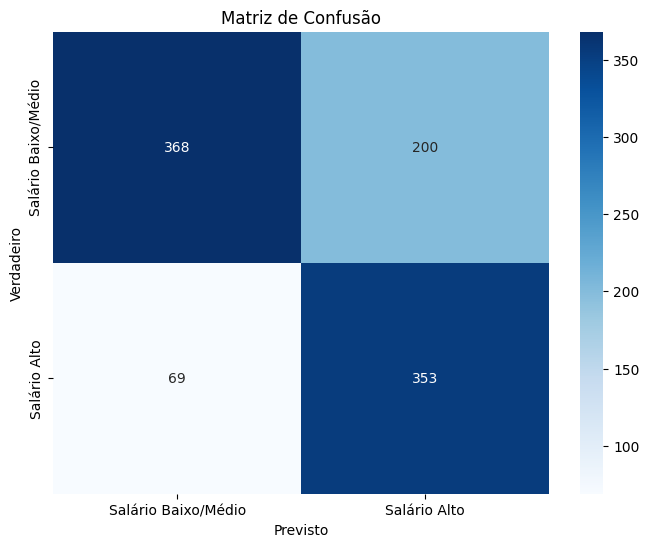

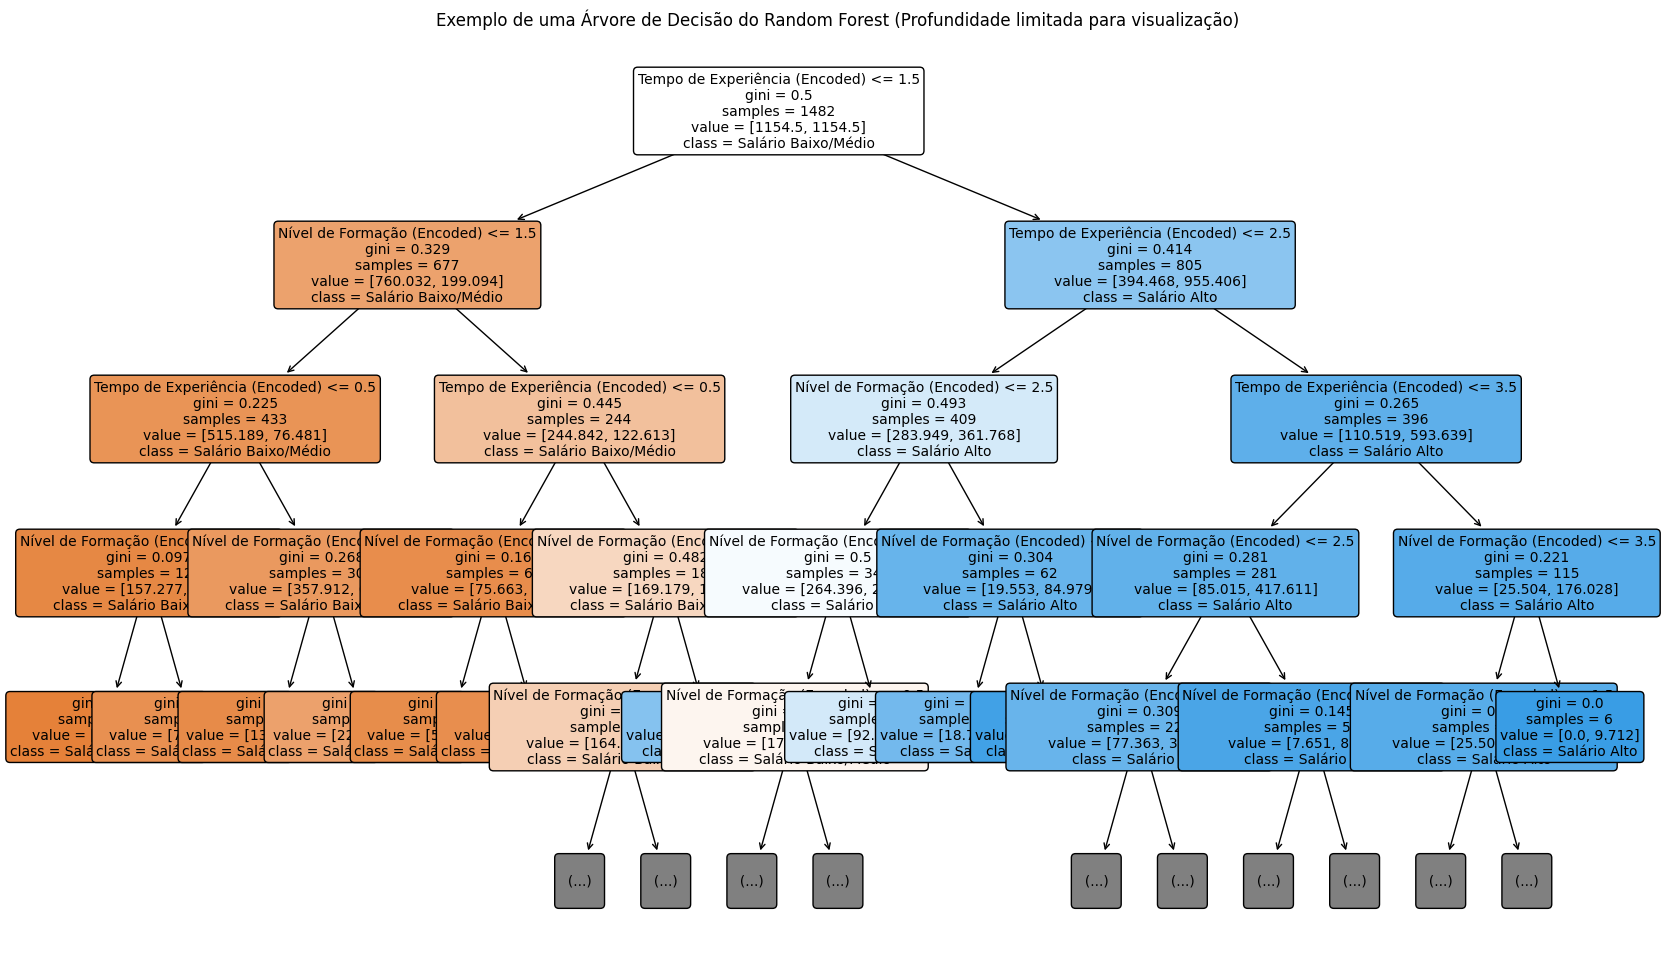

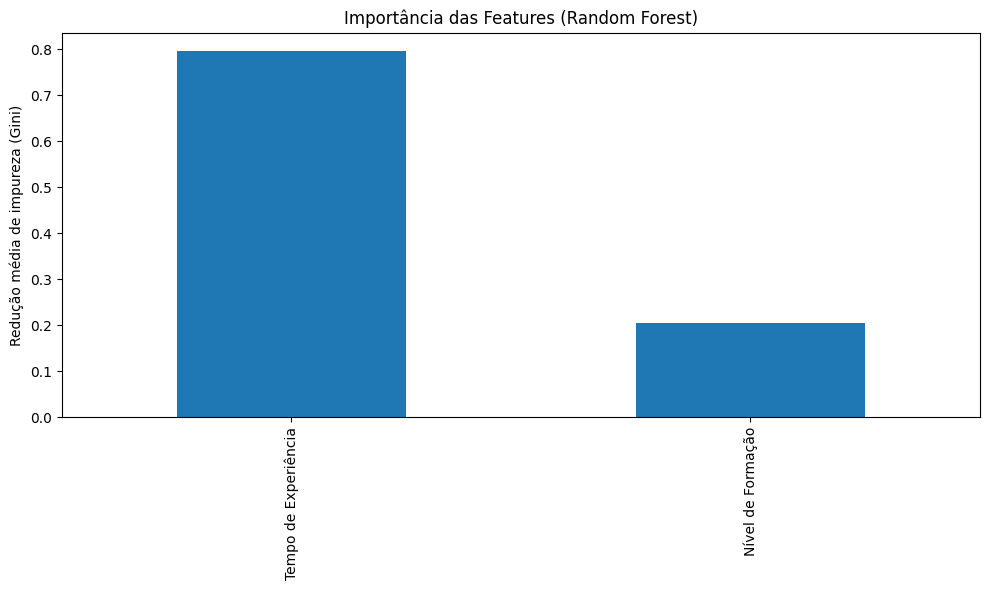

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

# --- Etapa 1: Carregamento e Pré-processamento dos Dados ---

# Carregar o dataset
# Certifique-se que o arquivo 'dados_limpos.csv' está no diretório correto ou forneça o caminho completo.
try:
    df = pd.read_csv('/kaggle/input/dataset-clean/dados_limpos.csv')
except FileNotFoundError:
    print("Arquivo 'dados_limpos.csv' não encontrado. "
          "Por favor, faça o upload do arquivo para o ambiente Kaggle ou ajuste o caminho.")
    exit()

# Selecionar colunas relevantes
colunas_features = ['Nível de ensino alcançado', 'Tempo de experiência na área de dados']
coluna_target = 'Faixa salarial mensal'
colunas_necessarias = colunas_features + [coluna_target]

# Remover linhas com valores ausentes nas colunas cruciais
df_limpo = df[colunas_necessarias].copy()
df_limpo.dropna(subset=colunas_necessarias, inplace=True)

# --- Etapa 2: Engenharia de Features e Criação da Variável Alvo ---

# Mapeamento ordinal para 'Nível de ensino alcançado'
nivel_ensino_map = {
    'Estudante de Graduação': 0,
    'Graduação/Bacharelado': 1,
    'Pós-graduação': 2,
    'Mestrado': 3,
    'Doutorado ou Phd': 4
}
df_limpo['formacao_academica_encoded'] = df_limpo['Nível de ensino alcançado'].map(nivel_ensino_map)

# Mapeamento ordinal para 'Tempo de experiência na área de dados'
# Verificar e listar todas as categorias únicas para garantir mapeamento completo
# print("Valores únicos para 'Tempo de experiência na área de dados':")
# print(df_limpo['Tempo de experiência na área de dados'].unique())
experiencia_map = {
    'Menos de 1 ano': 0,
    'de 1 a 2 anos': 1,
    'de 3 a 4 anos': 2,
    'de 4 a 6 anos': 3, # Comum em algumas pesquisas, verificar se existe no seu CSV
    'de 5 a 6 anos': 3, # Valor encontrado no snippet
    'de 7 a 10 anos': 4,
    'Mais de 10 anos': 5 # Adicionando caso exista
}
df_limpo['experiencia_profissional_encoded'] = df_limpo['Tempo de experiência na área de dados'].map(experiencia_map)


# Mapeamento ordinal para 'Faixa salarial mensal' para criar a variável alvo binária
# print("Valores únicos para 'Faixa salarial mensal':")
# print(df_limpo['Faixa salarial mensal'].unique())
salario_map_ordinal = {
    'Menos de R$ 1.000/mês': 0,
    'de R$ 1.001/mês a R$ 2.000/mês': 1,
    'de R$ 2.001/mês a R$ 3.000/mês': 2,
    'de R$ 3.001/mês a R$ 4.000/mês': 3,
    'de R$ 4.001/mês a R$ 6.000/mês': 4,
    'de R$ 6.001/mês a R$ 8.000/mês': 5,
    'de R$ 8.001/mês a R$ 12.000/mês': 6,
    'de R$ 12.001/mês a R$ 16.000/mês': 7,
    'de R$ 16.001/mês a R$ 20.000/mês': 8,
    'de R$ 20.001/mês a R$ 25.000/mês': 9,
    'de R$ 25.001/mês a R$ 30.000/mês': 10,
    'de R$ 30.001/mês a R$ 40.000/mês': 11,
    'Acima de R$ 40.001/mês': 12
}
df_limpo['faixa_salarial_encoded'] = df_limpo['Faixa salarial mensal'].map(salario_map_ordinal)

# Remover NaNs que podem surgir de mapeamentos incompletos (categorias não previstas nos maps)
df_limpo.dropna(subset=['formacao_academica_encoded', 
                         'experiencia_profissional_encoded', 
                         'faixa_salarial_encoded'], inplace=True)

# Criar variável alvo binária: 0 para salários mais baixos, 1 para salários mais altos
# O limiar aqui é <= 5 (até R$ 8.000). Ajuste conforme necessidade.
df_limpo['salario_alto'] = df_limpo['faixa_salarial_encoded'].apply(lambda x: 1 if x > 5 else 0)

# Preparar Features (X) e Target (y)
X = df_limpo[['formacao_academica_encoded', 'experiencia_profissional_encoded']]
y = df_limpo['salario_alto']

# Verificar se há dados suficientes após o pré-processamento
if X.shape[0] < 10 or len(y.unique()) < 2: # Adicionado len(y.unique()) < 2
    print("Não há dados suficientes ou classes suficientes após o pré-processamento para treinar o modelo.")
    print(f"Tamanho de X: {X.shape}, Classes em y: {y.unique()}")
    exit()


# Divisão dos dados em treino e teste
# Usar stratify=y se houver desbalanceamento de classes e for desejável manter a proporção
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --- Etapa 3: Desenvolvimento do Modelo de Machine Learning - Random Forest ---
# Parâmetros para buscar acurácia ótima e complexidade:
rf_model = RandomForestClassifier(
    n_estimators=250,         # Número aumentado de árvores
    max_depth=None,           # Permite que as árvores cresçam completamente (Random Forest lida bem com isso)
    min_samples_split=10,     # Aumentado para evitar overfitting em nós pequenos
    min_samples_leaf=5,       # Aumentado para folhas mais robustas
    class_weight='balanced_subsample', # Ajusta pesos para classes desbalanceadas em cada bootstrap
    random_state=42,
    n_jobs=-1                 # Utiliza todos os processadores disponíveis
)

rf_model.fit(X_train, y_train)

# Previsões
y_pred = rf_model.predict(X_test)

# --- Etapa 4: Avaliação do Modelo ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do Modelo: {accuracy:.4f}\n")

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Salário Baixo/Médio', 'Salário Alto']))

# Parâmetros do modelo treinado
print("\nParâmetros do Modelo Random Forest Utilizado:")
print(rf_model.get_params())

# --- Etapa 5: Geração de Gráficos ---

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Salário Baixo/Médio', 'Salário Alto'], 
            yticklabels=['Salário Baixo/Médio', 'Salário Alto'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

# Exemplo de uma Árvore de Decisão da Floresta
# Escolher uma árvore (ex: a primeira, rf_model.estimators_[0])
# Nomes das features para o gráfico da árvore
feature_names_tree = ['Nível de Formação (Encoded)', 'Tempo de Experiência (Encoded)']
class_names_tree = ['Salário Baixo/Médio', 'Salário Alto']

plt.figure(figsize=(20, 12)) # Aumentado para melhor visualização
plot_tree(rf_model.estimators_[0], 
          feature_names=feature_names_tree,
          class_names=class_names_tree, 
          filled=True, 
          rounded=True, 
          impurity=True,
          proportion=False,
          fontsize=10,
          max_depth=4) # Limitar a profundidade da plotagem para legibilidade
plt.title('Exemplo de uma Árvore de Decisão do Random Forest (Profundidade limitada para visualização)')
plt.show()

# Importância das Features
importances = rf_model.feature_importances_
feature_names_importances = ['Nível de Formação', 'Tempo de Experiência'] # Nomes para o gráfico
forest_importances = pd.Series(importances, index=feature_names_importances)

fig, ax = plt.subplots(figsize=(10,6))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Importância das Features (Random Forest)")
ax.set_ylabel("Redução média de impureza (Gini)")
fig.tight_layout()
plt.show()